In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector

# Encoders 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import make_column_selector

from sklearn.model_selection import train_test_split

In [1]:
X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_test = pd.read_csv("X_test_tran.csv")
y_test = pd.read_csv("y_test_tran.csv")
myColumns = X_train.columns
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

NameError: name 'pd' is not defined

In [116]:
df = pd.read_csv("Customer-Churn-Records.csv")


df = df.drop(columns=['RowNumber','CustomerId'])
df = df.drop(columns=['Complain'])
df = df.rename(columns={'Card Type': 'CardType'})
df = df.rename(columns={'Point Earned': 'PointsEarned'})
df = df.rename(columns={'Geography': 'Country'})
df = df.rename(columns={'Satisfaction Score': 'SatisfactionScore'})
# save original columns
myColumns_df = df.columns

In [42]:
X_train.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Satisfaction Score,CreditScoreOrd,AgeOrd,TaxBracket,BalanceOrd,PointsEarnedQuant,CardTypeOrd,SurnameOrd,CountryOrd,CountryHappy,GenderBinary
0,2,2,1,0,2,3,1,4,0,1.0,1.0,0.0,1,6.48,0
1,1,1,1,1,1,4,1,3,1,2.0,2.0,0.0,2,6.69,0
2,2,1,0,1,1,4,4,4,3,2.0,0.0,0.0,2,6.69,0
3,4,1,1,0,1,2,1,1,2,0.0,2.0,2.0,3,7.03,1
4,8,2,0,1,3,3,3,3,0,2.0,0.0,0.0,2,6.69,1


In [66]:
#
#* So we get the numeric and object (i.e. string) columns separated

numeric_column_selector = make_column_selector(dtype_include=np.number)
num_cols = numeric_column_selector(X_train)
print(num_cols)

object_column_selector = make_column_selector(dtype_include='object')
object_cols = object_column_selector(X_train)
object_cols

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Satisfaction Score', 'CreditScoreOrd', 'AgeOrd', 'TaxBracket', 'BalanceOrd', 'PointsEarnedQuant', 'CardTypeOrd', 'SurnameOrd', 'CountryOrd', 'CountryHappy', 'GenderBinary']


[]

<font color='skyBlue'> 
We start by looking at how an un-optimized RandomForest classifier rates the feature importance

I compare the feature importance between the transformed dataset and the original churn dataset. To be able to compare i use a pretty standard pipeline with onehot, ordinal, and robustscaler.
</font>

In [108]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier



y_train = np.ravel(y_train)

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_train), [len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)[i]) for i in np.unique(y_train)]))
class_weights


# Create a Random Forest classifier
rf_model = RandomForestClassifier(class_weight=class_weights)


# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top n important features
n = 5  # Number of top features to display
n = len(X_train.columns)  # Number of top features to display
top_features = importance_df.head(n)
print(f"Top {n} important features:")
print(top_features)
 
 
 
 # Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
#* NuOfProducts is more important than was shown in the correlation map!
#* Tenure is also more important now than was shown on the correlation map.
#* Surprised gender is not used to a more significant degree
#* Surname encoding seems to not have worked
#* Wonder why balance and income are not very close to each other
#* Country could most likely be used better

Top 15 important features:
               Feature  Importance
6               AgeOrd    0.157216
1        NumOfProducts    0.132206
0               Tenure    0.113321
8           BalanceOrd    0.083931
4   Satisfaction Score    0.076271
9    PointsEarnedQuant    0.075792
5       CreditScoreOrd    0.071026
10         CardTypeOrd    0.064176
7           TaxBracket    0.056823
3       IsActiveMember    0.041327
13        CountryHappy    0.034906
12          CountryOrd    0.029350
14        GenderBinary    0.027556
2            HasCrCard    0.027498
11          SurnameOrd    0.008602
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       796
           1       0.82      0.48      0.60       204

    accuracy                           0.87      1000
   macro avg       0.85      0.72      0.76      1000
weighted avg       0.87      0.87      0.86      1000



In [114]:

X = df.drop(['Exited','Surname'], axis=1) # I drop Surname since we have not encoded it
y = df['Exited']
# yy = np.ravel(y)
X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X, y, test_size=0.2, random_state=40)


# Define the categorical features for one-hot encoding
categorical_features = ['Country', 'Gender', 'HasCrCard', 'IsActiveMember','CardType']

# Define the ordinal features for ordinal encoding
ordinal_features = ['Tenure', 'NumOfProducts', 'SatisfactionScore']

# Define the continuous features for scaling
continuous_features = ['CreditScore', 'Age', 'Balance', 'PointsEarned', 'EstimatedSalary']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('scaler', RobustScaler(), continuous_features) # For potential outliers
    ])

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_trainDF), [len(y_trainDF) / (len(np.unique(y_trainDF)) * np.bincount(y_trainDF)[i]) for i in np.unique(y_trainDF)]))
class_weights

# Define the Random Forest classifier
classifier = RandomForestClassifier(class_weight=class_weights)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


# Fit the pipeline to the training data
pipeline.fit(X_trainDF, y_trainDF)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
    print(feature, importance)

# Make predictions on the test set
y_pred = pipeline.predict(X_testDF)

# Generate the classification report
report = classification_report(y_testDF, y_pred)
print("Classification Report:")
print(report)

#* We can see that my transformations did make some difference but its a bit hard to interpret when you onehot encode. Age and NumOfProducts seems to still be of similar importance. TaxBracket is valued as more important here as well as country. 'separating' countries with onehot might help the model. Perhaps the feature differences will play a bigger role when it comes to hyperparameter tuning
#! The classification report shows a slight better score. However , since the datasets are shuffled differently this could be the main reason. Recall for 1 is really bad for both



Feature Importances:
scaler__Age 0.21532495864734114
ordinal__NumOfProducts 0.10905528027600411
scaler__Balance 0.10378124411321371
scaler__PointsEarned 0.09800338828814736
scaler__EstimatedSalary 0.09729860281483212
scaler__CreditScore 0.09561758033598451
ordinal__Tenure 0.06266580672254692
ordinal__SatisfactionScore 0.043006175097403246
onehot__Country_Germany 0.022242912823716644
onehot__IsActiveMember_1 0.019811342309359246
onehot__IsActiveMember_0 0.0193560547583455
onehot__Country_France 0.01265458639553172
onehot__CardType_DIAMOND 0.012091537965901036
onehot__CardType_SILVER 0.01205720201695805
onehot__CardType_GOLD 0.012031966889740753
onehot__CardType_PLATINUM 0.01152909065093833
onehot__Gender_Male 0.011331517746690032
onehot__HasCrCard_1 0.010824920893905647
onehot__HasCrCard_0 0.010779761124900264
onehot__Gender_Female 0.01066727189309461
onehot__Country_Spain 0.009868798235445004
Classification Report:
              precision    recall  f1-score   support

           0    

<font color='skyBlue'> 
Lets look at mutual information for both the transformed and original data
</font>

In [137]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
X_train_num = X_train[['Tenure', 'NumOfProducts','Satisfaction Score', 'PointsEarnedQuant','AgeOrd','TaxBracket','BalanceOrd',]]
mutual_info = mutual_info_classif(X_train_num, y_train)
mutual_info

array([0.        , 0.06764271, 0.        , 0.        , 0.06305002,
       0.        , 0.01876155])

In [138]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num.columns
mutual_info.sort_values(ascending=False)

NumOfProducts         0.067643
AgeOrd                0.063050
BalanceOrd            0.018762
Tenure                0.000000
Satisfaction Score    0.000000
PointsEarnedQuant     0.000000
TaxBracket            0.000000
dtype: float64

<Axes: >

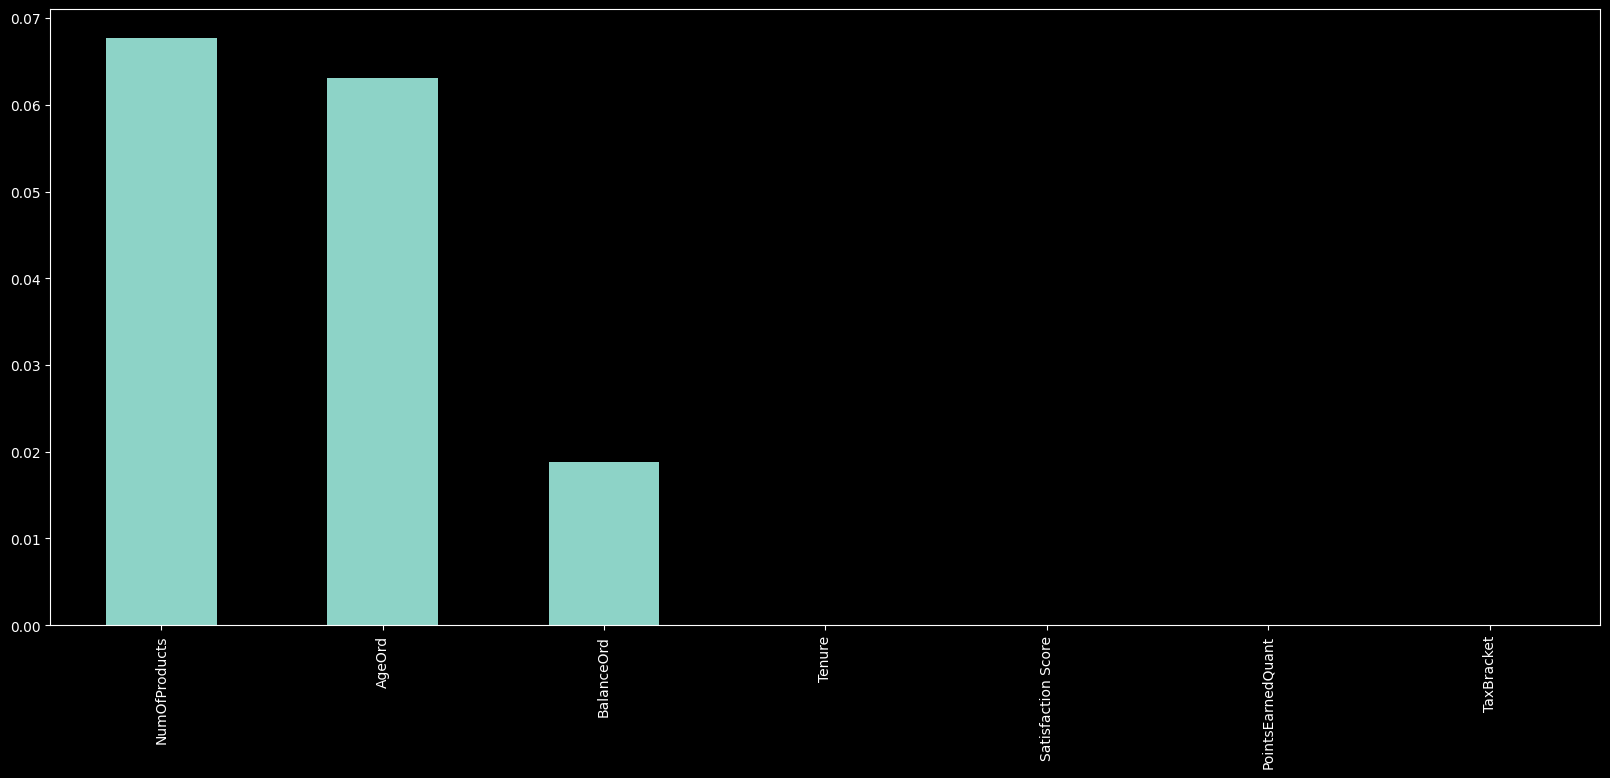

In [139]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

#* After Balance, the features have very low scores

In [142]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
X_trainDF_num = X_trainDF[['Age', 'Tenure','Balance', 'NumOfProducts','EstimatedSalary','SatisfactionScore','PointsEarned',]]
mutual_info222 = mutual_info_classif(X_trainDF_num, y_trainDF)
mutual_info222

array([0.07126733, 0.00090107, 0.00798181, 0.07240609, 0.00592067,
       0.        , 0.00080024])

In [143]:
mutual_info222 = pd.Series(mutual_info222)
mutual_info222.index = X_trainDF_num.columns
mutual_info222.sort_values(ascending=False)

NumOfProducts        0.072406
Age                  0.071267
Balance              0.007982
EstimatedSalary      0.005921
Tenure               0.000901
PointsEarned         0.000800
SatisfactionScore    0.000000
dtype: float64

<Axes: >

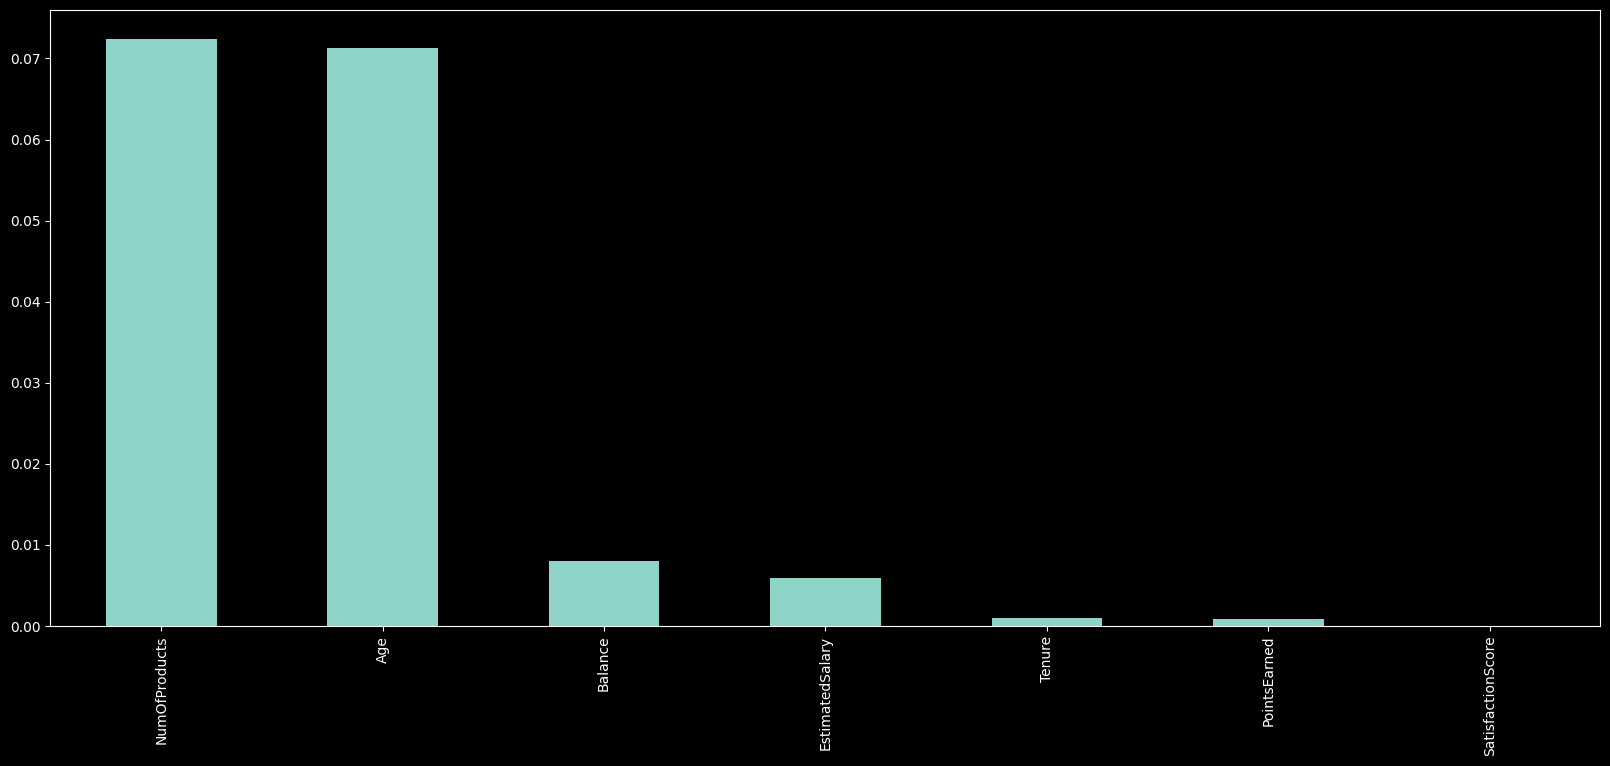

In [144]:
#let's plot the ordered mutual_info values per feature
mutual_info222.sort_values(ascending=False).plot.bar(figsize=(20, 8))

#* Balance gets a lower score but EstimatedSalary, and Tenure get a higher score

<font color='skyBlue'> 
Let us also look at the categorical features in a similar way using chi-square test.
We dont need to test both transformed and original since they are in the same format.
</font>

In [145]:
from sklearn.feature_selection import chi2
# * We will consider binary features as categorical
# * Surname is not really categegorical now after it has been encoded
X_train_cat = X_train[['GenderBinary', 'CountryOrd','SurnameOrd','HasCrCard','IsActiveMember']]
f_p_values=chi2(X_train_cat ,y_train)

In [149]:
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=categorical_df.columns
p_values.sort_values(ascending=True)
#* HasCrCard and Surname are above the standard 0.05, so we can view them as not significant

IsActiveMember    3.750575e-20
GenderBinary      2.002341e-12
CountryOrd        1.054061e-10
HasCrCard         4.240394e-01
SurnameOrd        7.075608e-01
dtype: float64

<font color='skyBlue'> 
Let us take a look if classification remains mostly the same if we use PCA to reduce the features.
</font>

In [158]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Perform PCA with the desired percentage of variance
pca = PCA(0.95)  # 95% of variance
X_pca = pca.fit_transform(X_train)

# Transform the test data using the preprocessor
X_test_pca = pca.transform(X_test)


# Get the actual number of components that explain the desired variance
n_components = pca.n_components_

# Print the number of components and the explained variance ratio
print("Number of Components:", n_components)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

#* we reduce the features from 15 to 10. Which could be really advantageous if we had so much data so that it took a long time to train the model
#* This does tell us that even though there is not much correlation and information in the features according to the tests, the model can still find use for them.


Number of Components: 10
Explained Variance Ratio: [0.37360462 0.10230878 0.09119447 0.08921701 0.08714033 0.0556375
 0.05078668 0.04847998 0.03635011 0.02050438]


In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_pca, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_pca)


# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# * The results got worse and now 1 recall is even worse!


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       796
           1       0.67      0.29      0.41       204

    accuracy                           0.83      1000
   macro avg       0.75      0.63      0.65      1000
weighted avg       0.81      0.83      0.80      1000



In [161]:
from sklearn.decomposition import PCA

# Apply preprocessing only
X_preprocessed = preprocessor.transform(X_trainDF)

# Apply PCA
pca = PCA(0.95)
X_pca = pca.fit_transform(X_preprocessed)

# Fit the classifier on the transformed data
classifier.fit(X_pca, y_trainDF)

# Apply preprocessing and PCA on the test data
X_test_preprocessed = preprocessor.transform(X_testDF)
X_test_pca = pca.transform(X_test_preprocessed)

# Make predictions on the test set
y_pred = classifier.predict(X_test_pca)

# Generate the classification report
report = classification_report(y_testDF, y_pred)
print("Classification Report:")
print(report)

#* Interesting. the standard pipeline handles feature reduction using PCA better. Especially at predicting True positives.

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1616
           1       0.75      0.41      0.53       384

    accuracy                           0.86      2000
   macro avg       0.81      0.69      0.72      2000
weighted avg       0.85      0.86      0.84      2000



In [163]:
# Define the categorical features for one-hot encoding
categorical_features = ['Country', 'Gender', 'HasCrCard', 'IsActiveMember','CardType']

# Define the ordinal features for ordinal encoding
ordinal_features = ['Tenure', 'NumOfProducts', 'SatisfactionScore']

# Define the continuous features for scaling
continuous_features = ['CreditScore', 'Age', 'Balance', 'PointsEarned', 'EstimatedSalary']

target_enc_features = ['Tenure', 'NumOfProducts', 'SatisfactionScore', 'Country', 'Gender', 'HasCrCard', 'IsActiveMember','CardType']

from category_encoders import TargetEncoder


# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # ('onehot', OneHotEncoder(), categorical_features),
        ('ordinal', TargetEncoder(), target_enc_features),
        ('scaler', RobustScaler(), continuous_features) # For potential outliers
    ])

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_trainDF), [len(y_trainDF) / (len(np.unique(y_trainDF)) * np.bincount(y_trainDF)[i]) for i in np.unique(y_trainDF)]))
class_weights

# Define the Random Forest classifier
classifier = RandomForestClassifier(class_weight=class_weights)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


# Fit the pipeline to the training data
pipeline.fit(X_trainDF, y_trainDF)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
    print(feature, importance)

# Make predictions on the test set
y_pred = pipeline.predict(X_testDF)

# Generate the classification report
report = classification_report(y_testDF, y_pred)
print("Classification Report:")
print(report)


Feature Importances:
scaler__Age 0.22131009531500961
ordinal__NumOfProducts 0.12385870438946114
scaler__Balance 0.10960234464465342
scaler__EstimatedSalary 0.10035020671961878
scaler__PointsEarned 0.0999701996469128
scaler__CreditScore 0.09788809106287184
ordinal__Tenure 0.060200286471170365
ordinal__Country 0.04244402467377679
ordinal__SatisfactionScore 0.04071886855802008
ordinal__IsActiveMember 0.03587356452559137
ordinal__CardType 0.03384891465081459
ordinal__Gender 0.018885471229950202
ordinal__HasCrCard 0.015049228112148975
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1616
           1       0.79      0.48      0.60       384

    accuracy                           0.88      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.87      0.88      0.86      2000



In [167]:
X_train_cat = X_train[['GenderBinary', 'CountryOrd','SurnameOrd','HasCrCard','IsActiveMember']]

X_train_num = X_train[['Tenure', 'NumOfProducts','Satisfaction Score', 'PointsEarnedQuant','AgeOrd','TaxBracket','BalanceOrd',]]

target_enc_features = ['GenderBinary', 'CountryOrd','SurnameOrd','HasCrCard','IsActiveMember', 'Tenure', 'NumOfProducts','Satisfaction Score', 'PointsEarnedQuant','AgeOrd','TaxBracket','BalanceOrd']

from category_encoders import TargetEncoder


# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # ('onehot', OneHotEncoder(), categorical_features),
        ('target', TargetEncoder(), target_enc_features),
        # ('scaler', RobustScaler(), continuous_features) # For potential outliers
    ])

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_train), [len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)[i]) for i in np.unique(y_train)]))
class_weights

# Define the Random Forest classifier
classifier = RandomForestClassifier(class_weight=class_weights)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
    print(feature, importance)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Feature Importances:
target__AgeOrd 0.1644197883326881
target__Tenure 0.14662719153917708
target__NumOfProducts 0.1456577097300137
target__BalanceOrd 0.10015299034989841
target__PointsEarnedQuant 0.09690884146327763
target__Satisfaction Score 0.09538798291835833
target__TaxBracket 0.07044587643942084
target__CountryOrd 0.06263156477056862
target__IsActiveMember 0.04348065593029776
target__HasCrCard 0.03285407169761983
target__GenderBinary 0.031155643225858624
target__SurnameOrd 0.0102776836028211
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       796
           1       0.74      0.50      0.59       204

    accuracy                           0.86      1000
   macro avg       0.81      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000

